# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
import pandas as pd
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Input

In [3]:
# loading the Fashion-MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

# trimming the data since it takes lot of time
X_train_full = X_train_full[:30000]
y_train_full = y_train_full[:30000]

X_test = X_test[:5000]
y_test = y_test[:5000]

# scaling the dataset
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# dividing the dataset into traingin and validation set
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]


# scaling the dataset
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Learning Rate Schedules

We will look at different learning rate schedules here

## Power Rate Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [8]:
# defining exponential decay without hardcoding
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [9]:
# defining the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 5

In [10]:
# LearningRateScheduler update the optimizer’s learning_rate
# attribute at the beginning of each epoch
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# training the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 25000 samples, validate on 5000 samples
Epoch 1/5
25000/25000 [==============================] - 4s 178us/sample - loss: 0.9128 - accuracy: 0.7455 - val_loss: 0.8480 - val_accuracy: 0.7428
Epoch 2/5
25000/25000 [==============================] - 4s 152us/sample - loss: 0.6547 - accuracy: 0.7936 - val_loss: 0.7723 - val_accuracy: 0.7556
Epoch 3/5
25000/25000 [==============================] - 4s 159us/sample - loss: 0.5880 - accuracy: 0.8153 - val_loss: 0.8921 - val_accuracy: 0.7842
Epoch 4/5
25000/25000 [==============================] - 4s 162us/sample - loss: 0.5404 - accuracy: 0.8286 - val_loss: 0.6437 - val_accuracy: 0.8174
Epoch 5/5
25000/25000 [==============================] - 4s 159us/sample - loss: 0.4576 - accuracy: 0.8532 - val_loss: 0.6813 - val_accuracy: 0.7956


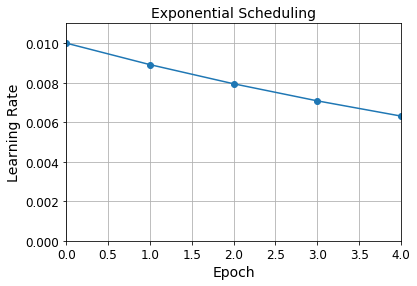

In [11]:
# plotting the learning rate by epoch for exponential scheduling
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [12]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))
        #print ("Learning Rate", lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

# defining the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(lr=lr0) # using Nadam optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]) # compiling the model
n_epochs = 5

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)

# training the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Train on 25000 samples, validate on 5000 samples
Epoch 1/5
Learning Rate 0.01
   32/25000 [..............................] - ETA: 8:47 - loss: 2.6560 - accuracy: 0.0938Learning Rate 0.009998526
Learning Rate 0.009997053
Learning Rate 0.00999558
Learning Rate 0.009994106
Learning Rate 0.009992634
Learning Rate 0.0099911615
Learning Rate 0.009989689
Learning Rate 0.009988217
Learning Rate 0.009986745
Learning Rate 0.009985274
  352/25000 [..............................] - ETA: 51s - loss: 4.9726 - accuracy: 0.4915 Learning Rate 0.009983802
Learning Rate 0.009982331
Learning Rate 0.00998086
Learning Rate 0.00997939
Learning Rate 0.009977919
Learning Rate 0.0099764485
Learning Rate 0.009974979
Learning Rate 0.009973509
Learning Rate 0.00997204
  640/25000 [..............................] - ETA: 29s - loss: 3.9639 - accuracy: 0.5609Learning Rate 0.00997057
Learning Rate 0.0099691
Learning Rate 0.009967632
Learning Rate 0.009966163
Learning Rate 0.009964694
Learning Rate 0.009963226
Learning

Learning Rate 0.009668162
 7360/25000 [=======>......................] - ETA: 4s - loss: 1.2356 - accuracy: 0.7162Learning Rate 0.009666737
Learning Rate 0.009665313
Learning Rate 0.009663889
Learning Rate 0.009662465
Learning Rate 0.009661041
Learning Rate 0.009659617
Learning Rate 0.009658194
Learning Rate 0.009656771
Learning Rate 0.009655348
Learning Rate 0.009653925
 7680/25000 [========>.....................] - ETA: 4s - loss: 1.2087 - accuracy: 0.7201Learning Rate 0.009652503
Learning Rate 0.009651081
Learning Rate 0.009649659
Learning Rate 0.009648236
Learning Rate 0.009646814
Learning Rate 0.009645393
Learning Rate 0.009643972
Learning Rate 0.009642551
Learning Rate 0.0096411295
 7968/25000 [========>.....................] - ETA: 4s - loss: 1.1897 - accuracy: 0.7213Learning Rate 0.009639709
Learning Rate 0.009638289
Learning Rate 0.009636869
Learning Rate 0.009635448
Learning Rate 0.009634028
Learning Rate 0.009632609
Learning Rate 0.0096311895
Learning Rate 0.00962977
Learnin

14720/25000 [================>.............] - ETA: 2s - loss: 0.9837 - accuracy: 0.7393Learning Rate 0.009344584
Learning Rate 0.009343207
Learning Rate 0.00934183
Learning Rate 0.009340454
Learning Rate 0.009339077
Learning Rate 0.009337701
Learning Rate 0.009336325
Learning Rate 0.00933495
Learning Rate 0.009333574
15008/25000 [=================>............] - ETA: 2s - loss: 0.9792 - accuracy: 0.7403Learning Rate 0.009332199
Learning Rate 0.009330823
Learning Rate 0.009329448
Learning Rate 0.009328074
Learning Rate 0.009326699
Learning Rate 0.009325325
Learning Rate 0.009323951
Learning Rate 0.009322577
Learning Rate 0.009321203
15296/25000 [=================>............] - ETA: 2s - loss: 0.9716 - accuracy: 0.7420Learning Rate 0.00931983
Learning Rate 0.009318456
Learning Rate 0.009317083
Learning Rate 0.0093157105
Learning Rate 0.009314338
Learning Rate 0.009312965
Learning Rate 0.009311592
Learning Rate 0.00931022
Learning Rate 0.0093088485
15584/25000 [=================>.....

Learning Rate 0.009035828
Learning Rate 0.009034496
Learning Rate 0.009033165
Learning Rate 0.009031834
Learning Rate 0.009030503
22176/25000 [=========================>....] - ETA: 0s - loss: 0.8908 - accuracy: 0.7523Learning Rate 0.009029172
Learning Rate 0.0090278415
Learning Rate 0.009026512
Learning Rate 0.009025182
Learning Rate 0.009023852
Learning Rate 0.009022522
Learning Rate 0.009021192
Learning Rate 0.009019863
Learning Rate 0.009018534
Learning Rate 0.009017205
22496/25000 [=========================>....] - ETA: 0s - loss: 0.8894 - accuracy: 0.7522Learning Rate 0.009015876
Learning Rate 0.009014548
Learning Rate 0.00901322
Learning Rate 0.009011892
Learning Rate 0.009010564
Learning Rate 0.009009236
Learning Rate 0.009007908
Learning Rate 0.009006581
Learning Rate 0.009005254
22784/25000 [==========================>...] - ETA: 0s - loss: 0.8856 - accuracy: 0.7529Learning Rate 0.009003927
Learning Rate 0.0090026
Learning Rate 0.009001274
Learning Rate 0.008999947
Learning R

Learning Rate 0.008735988
Learning Rate 0.008734701
Learning Rate 0.008733414
Learning Rate 0.008732127
 4448/25000 [====>.........................] - ETA: 3s - loss: 0.6400 - accuracy: 0.7846Learning Rate 0.00873084
Learning Rate 0.008729554
Learning Rate 0.008728268
Learning Rate 0.0087269815
Learning Rate 0.008725695
Learning Rate 0.008724409
Learning Rate 0.008723124
Learning Rate 0.008721839
Learning Rate 0.0087205535
Learning Rate 0.008719268
 4768/25000 [====>.........................] - ETA: 3s - loss: 0.6303 - accuracy: 0.7873Learning Rate 0.008717983
Learning Rate 0.008716699
Learning Rate 0.008715414
Learning Rate 0.00871413
Learning Rate 0.008712846
Learning Rate 0.008711562
Learning Rate 0.008710278
Learning Rate 0.008708995
Learning Rate 0.0087077115
 5056/25000 [=====>........................] - ETA: 3s - loss: 0.6322 - accuracy: 0.7884Learning Rate 0.008706428
Learning Rate 0.008705145
Learning Rate 0.008703862
Learning Rate 0.00870258
Learning Rate 0.008701297
Learning

11680/25000 [=============>................] - ETA: 2s - loss: 0.6297 - accuracy: 0.7910Learning Rate 0.008444853
Learning Rate 0.008443609
Learning Rate 0.008442365
Learning Rate 0.00844112
Learning Rate 0.008439876
Learning Rate 0.008438633
Learning Rate 0.0084373895
Learning Rate 0.008436146
Learning Rate 0.008434903
11968/25000 [=============>................] - ETA: 2s - loss: 0.6349 - accuracy: 0.7903Learning Rate 0.00843366
Learning Rate 0.008432417
Learning Rate 0.008431175
Learning Rate 0.008429932
Learning Rate 0.00842869
Learning Rate 0.008427448
Learning Rate 0.008426206
Learning Rate 0.008424965
Learning Rate 0.008423723
12256/25000 [=============>................] - ETA: 2s - loss: 0.6349 - accuracy: 0.7904Learning Rate 0.008422482
Learning Rate 0.00842124
Learning Rate 0.00842
Learning Rate 0.008418759
Learning Rate 0.008417519
Learning Rate 0.008416278
Learning Rate 0.008415038
Learning Rate 0.008413798
Learning Rate 0.008412559
12544/25000 [==============>.............

Learning Rate 0.008165826
Learning Rate 0.008164623
Learning Rate 0.00816342
Learning Rate 0.008162216
19104/25000 [=====================>........] - ETA: 1s - loss: 0.6650 - accuracy: 0.7881Learning Rate 0.008161014
Learning Rate 0.008159812
Learning Rate 0.008158609
Learning Rate 0.008157407
Learning Rate 0.008156205
Learning Rate 0.008155003
Learning Rate 0.008153802
Learning Rate 0.0081526
19360/25000 [======================>.......] - ETA: 1s - loss: 0.6659 - accuracy: 0.7875Learning Rate 0.008151399
Learning Rate 0.008150198
Learning Rate 0.008148996
Learning Rate 0.008147796
Learning Rate 0.008146595
Learning Rate 0.008145395
Learning Rate 0.008144194
Learning Rate 0.008142994
Learning Rate 0.008141794
19648/25000 [======================>.......] - ETA: 0s - loss: 0.6681 - accuracy: 0.7865Learning Rate 0.008140595
Learning Rate 0.008139395
Learning Rate 0.008138196
Learning Rate 0.008136996
Learning Rate 0.008135797
Learning Rate 0.008134599
Learning Rate 0.0081334
Learning Rate

 1184/25000 [>.............................] - ETA: 4s - loss: 0.6449 - accuracy: 0.7981Learning Rate 0.0078983465
Learning Rate 0.007897182
Learning Rate 0.007896019
Learning Rate 0.007894856
Learning Rate 0.007893693
Learning Rate 0.0078925295
Learning Rate 0.007891366
Learning Rate 0.007890203
Learning Rate 0.007889041
 1472/25000 [>.............................] - ETA: 4s - loss: 0.6320 - accuracy: 0.8043Learning Rate 0.007887878
Learning Rate 0.007886716
Learning Rate 0.007885554
Learning Rate 0.007884392
Learning Rate 0.00788323
Learning Rate 0.007882069
Learning Rate 0.0078809075
Learning Rate 0.007879746
Learning Rate 0.007878585
Learning Rate 0.007877423
 1792/25000 [=>............................] - ETA: 4s - loss: 0.6032 - accuracy: 0.8103Learning Rate 0.007876263
Learning Rate 0.007875103
Learning Rate 0.007873942
Learning Rate 0.007872782
Learning Rate 0.007871621
Learning Rate 0.007870462
Learning Rate 0.007869302
Learning Rate 0.007868143
Learning Rate 0.007866983
 2080/

Learning Rate 0.007636252
 8544/25000 [=========>....................] - ETA: 2s - loss: 0.5857 - accuracy: 0.8088Learning Rate 0.007635127
Learning Rate 0.007634002
Learning Rate 0.0076328767
Learning Rate 0.007631752
Learning Rate 0.0076306276
Learning Rate 0.007629503
Learning Rate 0.007628379
Learning Rate 0.007627255
Learning Rate 0.0076261307
 8832/25000 [=========>....................] - ETA: 2s - loss: 0.5870 - accuracy: 0.8077Learning Rate 0.007625007
Learning Rate 0.0076238834
Learning Rate 0.00762276
Learning Rate 0.0076216366
Learning Rate 0.0076205134
Learning Rate 0.0076193907
Learning Rate 0.007618268
Learning Rate 0.0076171453
Learning Rate 0.007616023
 9120/25000 [=========>....................] - ETA: 2s - loss: 0.5838 - accuracy: 0.8086Learning Rate 0.007614901
Learning Rate 0.0076137786
Learning Rate 0.007612657
Learning Rate 0.007611535
Learning Rate 0.0076104132
Learning Rate 0.007609292
Learning Rate 0.0076081706
Learning Rate 0.0076070493
Learning Rate 0.0076059

Learning Rate 0.0073850295
Learning Rate 0.007383941
15840/25000 [==================>...........] - ETA: 1s - loss: 0.6100 - accuracy: 0.8037Learning Rate 0.007382853
Learning Rate 0.007381765
Learning Rate 0.0073806774
Learning Rate 0.0073795896
Learning Rate 0.0073785023
Learning Rate 0.007377415
Learning Rate 0.0073763276
Learning Rate 0.007375241
Learning Rate 0.007374154
Learning Rate 0.0073730676
16160/25000 [==================>...........] - ETA: 1s - loss: 0.6096 - accuracy: 0.8037Learning Rate 0.007371981
Learning Rate 0.007370895
Learning Rate 0.007369809
Learning Rate 0.007368723
Learning Rate 0.007367637
Learning Rate 0.0073665516
Learning Rate 0.007365466
Learning Rate 0.0073643806
Learning Rate 0.0073632956
16448/25000 [==================>...........] - ETA: 1s - loss: 0.6076 - accuracy: 0.8045Learning Rate 0.0073622107
Learning Rate 0.0073611257
Learning Rate 0.007360041
Learning Rate 0.0073589566
Learning Rate 0.007357872
Learning Rate 0.007356788
Learning Rate 0.007355

Learning Rate 0.0071420735
Learning Rate 0.007141021
Learning Rate 0.0071399687
Learning Rate 0.0071389168
Learning Rate 0.007137865
Learning Rate 0.007136813
Learning Rate 0.0071357614
23264/25000 [==========================>...] - ETA: 0s - loss: 0.5839 - accuracy: 0.8109Learning Rate 0.00713471
Learning Rate 0.0071336585
Learning Rate 0.0071326075
Learning Rate 0.0071315565
Learning Rate 0.0071305055
Learning Rate 0.007129455
Learning Rate 0.0071284045
Learning Rate 0.007127354
Learning Rate 0.007126304
Learning Rate 0.007125254
23584/25000 [===========================>..] - ETA: 0s - loss: 0.5835 - accuracy: 0.8109Learning Rate 0.0071242037
Learning Rate 0.007123154
Learning Rate 0.0071221045
Learning Rate 0.007121055
Learning Rate 0.007120006
Learning Rate 0.0071189567
Learning Rate 0.0071179075
Learning Rate 0.007116859
Learning Rate 0.00711581
Learning Rate 0.0071147615
23904/25000 [===========================>..] - ETA: 0s - loss: 0.5848 - accuracy: 0.8109Learning Rate 0.007113

Learning Rate 0.006909146
Learning Rate 0.006908128
Learning Rate 0.00690711
Learning Rate 0.006906092
 5344/25000 [=====>........................] - ETA: 3s - loss: 0.4957 - accuracy: 0.8340Learning Rate 0.0069050747
Learning Rate 0.006904057
Learning Rate 0.0069030398
Learning Rate 0.0069020228
Learning Rate 0.0069010057
Learning Rate 0.0068999887
Learning Rate 0.006898972
Learning Rate 0.0068979557
Learning Rate 0.006896939
Learning Rate 0.006895923
 5664/25000 [=====>........................] - ETA: 3s - loss: 0.4915 - accuracy: 0.8349Learning Rate 0.006894907
Learning Rate 0.006893891
Learning Rate 0.006892875
Learning Rate 0.006891859
Learning Rate 0.0068908436
Learning Rate 0.006889828
Learning Rate 0.006888813
Learning Rate 0.0068877977
 5920/25000 [======>.......................] - ETA: 3s - loss: 0.4890 - accuracy: 0.8368Learning Rate 0.0068867826
Learning Rate 0.006885768
Learning Rate 0.0068847532
Learning Rate 0.0068837386
Learning Rate 0.0068827244
Learning Rate 0.0068817

Learning Rate 0.006681845
12512/25000 [==============>...............] - ETA: 2s - loss: 0.4939 - accuracy: 0.8362Learning Rate 0.0066808606
Learning Rate 0.0066798762
Learning Rate 0.006678892
Learning Rate 0.006677908
Learning Rate 0.006676924
Learning Rate 0.00667594
Learning Rate 0.006674956
Learning Rate 0.0066739726
12768/25000 [==============>...............] - ETA: 2s - loss: 0.4951 - accuracy: 0.8357Learning Rate 0.006672989
Learning Rate 0.0066720056
Learning Rate 0.0066710226
Learning Rate 0.0066700396
Learning Rate 0.0066690566
Learning Rate 0.006668074
Learning Rate 0.0066670915
Learning Rate 0.006666109
Learning Rate 0.006665127
13056/25000 [==============>...............] - ETA: 2s - loss: 0.4980 - accuracy: 0.8352Learning Rate 0.006664145
Learning Rate 0.0066631627
Learning Rate 0.0066621806
Learning Rate 0.006661199
Learning Rate 0.0066602174
Learning Rate 0.006659236
Learning Rate 0.0066582547
Learning Rate 0.0066572735
Learning Rate 0.0066562924
Learning Rate 0.00665

Learning Rate 0.00646488
Learning Rate 0.006463927
Learning Rate 0.006462975
Learning Rate 0.0064620227
19776/25000 [======================>.......] - ETA: 0s - loss: 0.4911 - accuracy: 0.8357Learning Rate 0.0064610704
Learning Rate 0.006460118
Learning Rate 0.0064591663
Learning Rate 0.0064582145
Learning Rate 0.0064572627
Learning Rate 0.0064563113
Learning Rate 0.00645536
Learning Rate 0.0064544086
Learning Rate 0.0064534578
20064/25000 [=======================>......] - ETA: 0s - loss: 0.4910 - accuracy: 0.8362Learning Rate 0.006452507
Learning Rate 0.006451556
Learning Rate 0.006450605
Learning Rate 0.0064496547
Learning Rate 0.0064487043
Learning Rate 0.006447754
Learning Rate 0.006446804
Learning Rate 0.006445854
Learning Rate 0.006444904
20352/25000 [=======================>......] - ETA: 0s - loss: 0.4903 - accuracy: 0.8365Learning Rate 0.0064439545
Learning Rate 0.006443005
Learning Rate 0.0064420556
Learning Rate 0.006441106
Learning Rate 0.006440157
Learning Rate 0.00643920

Learning Rate 0.0062540374
 1856/25000 [=>............................] - ETA: 4s - loss: 0.4006 - accuracy: 0.8669Learning Rate 0.006253116
Learning Rate 0.0062521943
Learning Rate 0.006251273
Learning Rate 0.006250352
Learning Rate 0.006249431
Learning Rate 0.00624851
Learning Rate 0.0062475894
Learning Rate 0.0062466688
Learning Rate 0.006245748
 2144/25000 [=>............................] - ETA: 3s - loss: 0.4002 - accuracy: 0.8657Learning Rate 0.006244828
Learning Rate 0.006243908
Learning Rate 0.0062429877
Learning Rate 0.0062420676
Learning Rate 0.006241148
Learning Rate 0.006240228
Learning Rate 0.0062393085
Learning Rate 0.0062383893
Learning Rate 0.00623747
 2432/25000 [=>............................] - ETA: 3s - loss: 0.3955 - accuracy: 0.8697Learning Rate 0.006236551
Learning Rate 0.0062356316
Learning Rate 0.006234713
Learning Rate 0.006233794
Learning Rate 0.0062328754
Learning Rate 0.006231957
Learning Rate 0.006231039
Learning Rate 0.0062301205
Learning Rate 0.006229202

Learning Rate 0.0060482887
 9120/25000 [=========>....................] - ETA: 2s - loss: 0.4337 - accuracy: 0.8599Learning Rate 0.0060473974
Learning Rate 0.006046506
Learning Rate 0.0060456153
Learning Rate 0.0060447245
Learning Rate 0.0060438337
Learning Rate 0.006042943
Learning Rate 0.0060420525
Learning Rate 0.006041162
 9376/25000 [==========>...................] - ETA: 2s - loss: 0.4350 - accuracy: 0.8594Learning Rate 0.006040272
Learning Rate 0.006039382
Learning Rate 0.006038492
Learning Rate 0.006037602
Learning Rate 0.0060367123
Learning Rate 0.006035823
Learning Rate 0.0060349335
Learning Rate 0.006034044
Learning Rate 0.006033155
 9664/25000 [==========>...................] - ETA: 2s - loss: 0.4328 - accuracy: 0.8598Learning Rate 0.006032266
Learning Rate 0.0060313772
Learning Rate 0.0060304883
Learning Rate 0.0060296
Learning Rate 0.0060287113
Learning Rate 0.006027823
Learning Rate 0.006026935
Learning Rate 0.006026047
 9920/25000 [==========>...................] - ETA:

Learning Rate 0.005857071
Learning Rate 0.005856208
Learning Rate 0.005855345
Learning Rate 0.0058544823
Learning Rate 0.0058536194
Learning Rate 0.005852757
Learning Rate 0.0058518946
Learning Rate 0.005851032
16320/25000 [==================>...........] - ETA: 1s - loss: 0.4265 - accuracy: 0.8587Learning Rate 0.00585017
Learning Rate 0.005849308
Learning Rate 0.005848446
Learning Rate 0.005847584
Learning Rate 0.0058467225
Learning Rate 0.005845861
Learning Rate 0.0058449996
Learning Rate 0.005844138
Learning Rate 0.005843277
Learning Rate 0.005842416
16640/25000 [==================>...........] - ETA: 1s - loss: 0.4261 - accuracy: 0.8585Learning Rate 0.005841555
Learning Rate 0.005840694
Learning Rate 0.0058398335
Learning Rate 0.005838973
Learning Rate 0.0058381124
Learning Rate 0.0058372524
Learning Rate 0.0058363923
Learning Rate 0.005835532
Learning Rate 0.005834672
16928/25000 [===================>..........] - ETA: 1s - loss: 0.4247 - accuracy: 0.8585Learning Rate 0.0058338125

23136/25000 [==========================>...] - ETA: 0s - loss: 0.4281 - accuracy: 0.8569Learning Rate 0.0056693912
Learning Rate 0.005668556
Learning Rate 0.0056677205
Learning Rate 0.005666885
Learning Rate 0.00566605
Learning Rate 0.005665215
Learning Rate 0.0056643803
Learning Rate 0.005663546
23392/25000 [===========================>..] - ETA: 0s - loss: 0.4273 - accuracy: 0.8574Learning Rate 0.0056627113
Learning Rate 0.005661877
Learning Rate 0.0056610424
Learning Rate 0.0056602084
Learning Rate 0.0056593744
Learning Rate 0.0056585404
23584/25000 [===========================>..] - ETA: 0s - loss: 0.4275 - accuracy: 0.8575Learning Rate 0.0056577064
Learning Rate 0.005656873
Learning Rate 0.0056560393
Learning Rate 0.005655206
Learning Rate 0.0056543723
Learning Rate 0.005653539
Learning Rate 0.005652706
Learning Rate 0.005651873
23840/25000 [===========================>..] - ETA: 0s - loss: 0.4264 - accuracy: 0.8578Learning Rate 0.0056510405
Learning Rate 0.005650208
Learning Rate

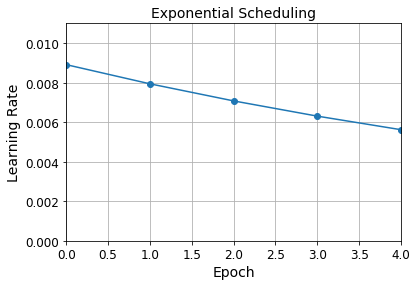

In [7]:
# plotting the learning rate by epoch for exponential scheduling
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Piecewise Constant Scheduling

In [13]:
# defining the epoch for piecewise constant scheduling
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [14]:
# defining piecewise constant scheduling
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

# calling the function
piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [16]:
# creating an instance of the LearningRateScheduler
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

# defining the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])

# compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 20

# training the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 4s 173us/sample - loss: 0.9096 - accuracy: 0.7474 - val_loss: 1.4445 - val_accuracy: 0.6518
Epoch 2/20
25000/25000 [==============================] - 5s 188us/sample - loss: 0.8224 - accuracy: 0.7619 - val_loss: 1.8735 - val_accuracy: 0.6500
Epoch 3/20
25000/25000 [==============================] - 4s 141us/sample - loss: 0.8986 - accuracy: 0.7555 - val_loss: 1.7711 - val_accuracy: 0.6578
Epoch 4/20
25000/25000 [==============================] - 4s 141us/sample - loss: 0.9058 - accuracy: 0.7348 - val_loss: 0.9819 - val_accuracy: 0.7138
Epoch 5/20
25000/25000 [==============================] - 3s 137us/sample - loss: 0.8147 - accuracy: 0.7630 - val_loss: 1.2003 - val_accuracy: 0.5984
Epoch 6/20
25000/25000 [==============================] - 3s 138us/sample - loss: 0.6695 - accuracy: 0.7494 - val_loss: 0.7413 - val_accuracy: 0.7258
Epoch 7/20
25000/25000 [===========================

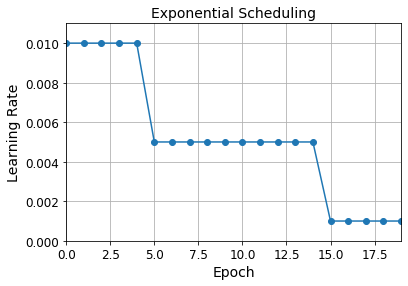

In [17]:
# plotting the learning rate by epoch for exponential scheduling
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Performance Scheduling

In [19]:
# using ReduceLROnPlateau callback for performance scheduling
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

# defining the model
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.02, momentum=0.9) # using momentum optimizer

# compiling the model
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20

# training the model
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Train on 25000 samples, validate on 5000 samples
Epoch 1/20
25000/25000 [==============================] - 3s 121us/sample - loss: 0.6757 - accuracy: 0.7817 - val_loss: 0.5789 - val_accuracy: 0.8188
Epoch 2/20
25000/25000 [==============================] - 3s 106us/sample - loss: 0.5250 - accuracy: 0.8263 - val_loss: 0.5487 - val_accuracy: 0.8262
Epoch 3/20
25000/25000 [==============================] - 3s 108us/sample - loss: 0.4851 - accuracy: 0.8427 - val_loss: 0.8095 - val_accuracy: 0.8310
Epoch 4/20
25000/25000 [==============================] - 3s 109us/sample - loss: 0.4719 - accuracy: 0.8460 - val_loss: 0.9283 - val_accuracy: 0.7864
Epoch 5/20
25000/25000 [==============================] - 3s 118us/sample - loss: 0.3010 - accuracy: 0.8897 - val_loss: 0.4652 - val_accuracy: 0.8586
Epoch 6/20
25000/25000 [==============================] - 3s 108us/sample - loss: 0.2511 - accuracy: 0.9059 - val_loss: 0.4036 - val_accuracy: 0.8826
Epoch 7/20
25000/25000 [===========================

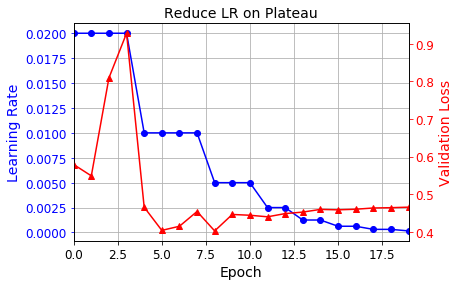

In [20]:
# plotting the learning rate by epoch for ReduceLROnPleatue
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1) # get current axes
plt.grid(True)

ax2 = plt.gca().twinx() # create twin axes
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()